In [1]:
import time
import tqdm
import math
import logging
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans,  MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, accuracy_score, mean_squared_error, pairwise_distances_argmin_min, confusion_matrix, homogeneity_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import tree

from new_jmlm import JMLM
from load_data import load_data
from isodata import isodata_classification


## Load Data

In [2]:
dataset = "mnist"
X_train, X_test, y_train, y_test = load_data(dataset)

print(f"Dataset: {dataset}")
print(X_train.shape)

Dataset: mnist
(60000, 784)


## Decision Tree

In [ ]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

y_pred = clf.predict(X_train)
acc = accuracy_score(y_train, y_pred)
print(f'Prediction Accuracy: {acc}')
y_pred = clf.predict(X_test)    
acc = accuracy_score(y_test, y_pred)
print(f'Prediction Accuracy: {acc}')

## MLP

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.20)
clf = MLPClassifier(hidden_layer_sizes=(10,  )).fit(X_train, y_train)

print(clf.score(X_valid, y_valid))

print(clf.score(X_test, y_test))

## K-means

In [ ]:
def infer_cluster_labels(kmeans, actual_labels):
    """
    Associates most probable label with each cluster in KMeans model
    returns: dictionary of clusters assigned to each label
    """

    inferred_labels = {}

    # Loop through the clusters
    for i in range(kmeans.n_clusters):

        # find index of points in cluster
        labels = []
        index = np.where(kmeans.labels_ == i)

        # append actual labels for each point in cluster
        labels.append(actual_labels[index])

        # determine most common label
        if len(labels[0]) == 1:
            counts = np.bincount(labels[0])
        else:
            counts = np.bincount(np.squeeze(labels))

        # assign the cluster to a value in the inferred_labels dictionary
        if np.argmax(counts) in inferred_labels:
            # append the new number to the existing array at this slot
            inferred_labels[np.argmax(counts)].append(i)
        else:
            # create a new array in this slot
            inferred_labels[np.argmax(counts)] = [i]
        
    return inferred_labels  

def infer_data_labels(X_labels, cluster_labels):
    """
    Determines label for each array, depending on the cluster it has been assigned to.
    returns: predicted labels for each array
    """
    
    # empty array of len(X)
    predicted_labels = np.zeros(len(X_labels)).astype(np.uint8)
    
    for i, cluster in enumerate(X_labels):
        for key, value in cluster_labels.items():
            if cluster in value:
                predicted_labels[i] = key
                
    return predicted_labels

def calc_metrics(estimator, data, labels):
    print('Number of Clusters: {}'.format(estimator.n_clusters))
    # Inertia
    inertia = estimator.inertia_
    print("Inertia: {}".format(inertia))
    # Homogeneity Score
    homogeneity = homogeneity_score(labels, estimator.labels_)
    print("Homogeneity score: {}".format(homogeneity))
    return inertia, homogeneity

def low_dim(X_train, X_test, y_train, n_pca=0, pca=True, lda=True):
    if pca:
        if n_pca == 0:
            n_pca = int(X_train.shape[1]*0.8)
        pca = PCA(n_components=n_pca)
        X_train = pca.fit_transform(X_train)
        X_test = pca.transform(X_test)
    if lda:
        clf = LinearDiscriminantAnalysis()
        X_train = clf.fit_transform(X_train, y_train.argmax(axis=1))
        X_test = clf.transform(X_test)
    return X_train, X_test

In [ ]:
X_train, X_test, y_train, y_test = load_data(dataset)

X_train, X_test = low_dim(X_train, X_test, y_train)

n_digits = len(np.unique(y_train))

kmeans = KMeans(n_clusters=256).fit(X_train)

cluster_labels = infer_cluster_labels(kmeans, y_train.argmax(axis=1))
X_train_clusters = kmeans.predict(X_train)
y_train_pred = infer_data_labels(X_train_clusters, cluster_labels)
acc_train = accuracy_score(y_train.argmax(axis=1), y_train_pred)
print(f'Train Prediction Accuracy: {acc_train}')

X_test_clusters = kmeans.predict(X_test)
y_test_pred = infer_data_labels(X_test_clusters, cluster_labels)
acc_test = accuracy_score(y_test.argmax(axis=1), y_test_pred)
print(f'Test Prediction Accuracy: {acc_test}')


In [ ]:
X_train, X_test, y_train, y_test = load_data(dataset, onehot=False)
clusters = [10, 16, 36, 64, 144, 256]
iner_list = []
homo_list = []
acc_list = []

for n_clusters in clusters:
    estimator = MiniBatchKMeans(n_clusters=n_clusters)
    estimator.fit(X_train)
    
    inertia, homo = calc_metrics(estimator, X_train, y_train)
    iner_list.append(inertia)
    homo_list.append(homo)
    
    # Determine predicted labels
    cluster_labels = infer_cluster_labels(estimator, y_train)
    prediction = infer_data_labels(estimator.labels_, cluster_labels)
    
    acc = accuracy_score(y_train, prediction)
    acc_list.append(acc)
    print('Accuracy: {}\n'.format(acc))

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16, 10))
ax[0].plot(clusters, iner_list, label='inertia', marker='o')
ax[1].plot(clusters, homo_list, label='homogeneity', marker='o')
ax[1].plot(clusters, acc_list, label='accuracy', marker='^')
ax[0].legend(loc='best')
ax[1].legend(loc='best')
ax[0].grid('on')
ax[1].grid('on')
ax[0].set_title('Inertia of each clusters')
ax[1].set_title('Homogeneity and Accuracy of each clusters')
fig.suptitle('matplotlib.axes.Axes.set_title() function Example\n')

plt.show()

## Random Forest

In [ ]:
clf = RandomForestClassifier(max_depth=500)

clf.fit(X_train, y_train)

y_Train_pred = clf.predict(X_train)

acc_train = accuracy_score(y_train, y_Train_pred)

print(f'Prediction Accuracy: {acc_train}')


y_pred = clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)

print(f'Prediction Accuracy: {acc}')

## XGBoost

In [ ]:
X_train, X_test, y_train, y_test = load_data(dataset, onehot=False)

xgb_model = xgb.XGBClassifier(objective="binary:logistic")
# xgb_model = xgb.XGBClassifier(objective="multi:softprob", random_state=42)

xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_train)

print(confusion_matrix(y_train, y_pred))
acc = accuracy_score(y_train, y_pred)
print(f'Prediction Accuracy: {acc}')

y_pred = xgb_model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
acc = accuracy_score(y_test, y_pred)
print(f'Prediction Accuracy: {acc}')

## Visualization

In [ ]:


dataset = "mnist"
X_train, X_test, y_train, y_test = load_data(dataset, onehot=False)
X = np.vstack((X_train, X_test)) / 255.0
y = np.append(y_train, y_test)

print(X.shape)
print(y.shape)

feat_cols = [ 'pixel' + str(i) for i in range(X.shape[1]) ]

df = pd.DataFrame(X,columns=feat_cols)
df['y'] = y
df['label'] = df['y'].apply(lambda i: str(i))

print('Size of the dataframe: {}'.format(df.shape))


rndperm = np.random.permutation(df.shape[0])

plt.gray()

fig = plt.figure( figsize=(16,7) )

for i in range(0, 5):
    ax = fig.add_subplot(1, 5, i+1, title="Digit: {}".format(str(df.loc[rndperm[i], 'label'])))

    ax.matshow(df.loc[rndperm[i],feat_cols].values.reshape((28,28)).astype(float))

plt.show()



In [ ]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(df[feat_cols].values)

df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 
df['pca-three'] = pca_result[:,2]

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

plt.figure(figsize=(16,10))

sns.scatterplot(
    x="pca-one", 
    y="pca-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=df.loc[rndperm,:],
    legend="full",
    alpha=0.3
)


ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=df.loc[rndperm,:]["pca-one"], 
    ys=df.loc[rndperm,:]["pca-two"], 
    zs=df.loc[rndperm,:]["pca-three"], 
    c=df.loc[rndperm,:]["y"], 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

In [ ]:
N = 10000

df_subset = df.loc[rndperm[:N],:].copy()

data_subset = df_subset[feat_cols].values

pca = PCA(n_components=3)
pca_result = pca.fit_transform(data_subset)

df_subset['pca-one'] = pca_result[:,0]
df_subset['pca-two'] = pca_result[:,1] 
df_subset['pca-three'] = pca_result[:,2]

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(data_subset)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))


In [ ]:

df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full",
    alpha=0.3
)

In [ ]:
test_data = pd.read_csv("D:/Applications/vscode/workspace/JMLM/datasets/ICU/ICU_ALL_DATA_test.txt", sep="	", header=None) 
train_data = pd.read_csv("D:/Applications/vscode/workspace/JMLM/datasets/ICU/ICU_ALL_DATA_train.txt", sep="	", header=None) 
# data = train_data.append(test_data, ignore_index=True)
data = [train_data, test_data]
data = pd.concat(data)
X = data.iloc[:, 1:10].to_numpy()
y = data.iloc[:, 0].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
print(X_train.shape)


## Tree graph

In [ ]:
import igraph
from igraph import Graph, EdgeSeq
nr_vertices = 25
v_label = list(map(str, range(nr_vertices)))
G = Graph.Tree(nr_vertices, 2) # 2 stands for children number
lay = G.layout('rt')

position = {k: lay[k] for k in range(nr_vertices)}
Y = [lay[k][1] for k in range(nr_vertices)]
M = max(Y)

es = EdgeSeq(G) # sequence of edges
E = [e.tuple for e in G.es] # list of edges

L = len(position)
Xn = [position[k][0] for k in range(L)]
Yn = [2*M-position[k][1] for k in range(L)]
Xe = []
Ye = []
for edge in E:
    Xe+=[position[edge[0]][0],position[edge[1]][0], None]
    Ye+=[2*M-position[edge[0]][1],2*M-position[edge[1]][1], None]

labels = v_label

In [ ]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=Xe,
                   y=Ye,
                   mode='lines',
                   line=dict(color='rgb(210,210,210)', width=1),
                   hoverinfo='none'
                   ))
fig.add_trace(go.Scatter(x=Xn,
                  y=Yn,
                  mode='markers',
                  name='bla',
                  marker=dict(symbol='circle-dot',
                                size=18,
                                color='#6175c1',    #'#DB4551',
                                line=dict(color='rgb(50,50,50)', width=1)
                                ),
                  text=labels,
                  hoverinfo='text',
                  opacity=0.8
                  ))

In [ ]:
def make_annotations(pos, text, font_size=10, font_color='rgb(250,250,250)'):
    L=len(pos)
    if len(text)!=L:
        raise ValueError('The lists pos and text must have the same len')
    annotations = []
    for k in range(L):
        annotations.append(
            dict(
                text=labels[k], # or replace labels with a different list for the text within the circle
                x=pos[k][0], y=2*M-position[k][1],
                xref='x1', yref='y1',
                font=dict(color=font_color, size=font_size),
                showarrow=False)
        )
    return annotations

In [ ]:
axis = dict(showline=False, # hide axis line, grid, ticklabels and  title
            zeroline=False,
            showgrid=False,
            showticklabels=False,
            )

fig.update_layout(title= 'Tree with Reingold-Tilford Layout',
              annotations=make_annotations(position, v_label),
              font_size=12,
              showlegend=False,
              xaxis=axis,
              yaxis=axis,
              margin=dict(l=40, r=40, b=85, t=100),
              hovermode='closest',
              plot_bgcolor='rgb(248,248,248)'
              )
fig.show()

In [ ]:
import igraph as ig
from igraph import Graph

# Set seed for reproducibility
import random
random.seed(123)

# Create an undirected tree. If your tree is not undirected, 
# convert it to undirected first.
g = Graph.Tree_Game(10)

# Our chosen root:
root = 3

ig.plot(g, vertex_label=range(g.vcount()), layout = g.layout_reingold_tilford(root=root), bbox=(300,300))

# Distances from the root, will be used for ordering:
dist=g.shortest_paths(source=root)[0]

# This function computes the permutation that would
# sort 'elems'. It also serves as a way to invert
# permutations.

def ordering(elems):
    return sorted(range(len(elems)), key=elems.__getitem__)

# Compute orderings based on the distance from the root:
perm = ordering(dist)
invperm = ordering(perm)

# Reorder, direct, restore order:
dg = g.permute_vertices(invperm)
dg.to_directed('acyclic')
dg = dg.permute_vertices(perm)

# Plot again.
# Now the root does not need to be given,
# as it is auto-detected from the directions.
ig.plot(dg, vertex_label=range(g.vcount()), layout='reingold_tilford', bbox=(300,300))

In [ ]:
import igraph as ig
g = ig.Graph(n = 12, directed=True)
g.add_edges([(1,0),(2,1), (3,2), (4,3),
         (5,1),
         (6,2), (7,6), (8,7),
         (9,0),
         (10,0), (11,10)])
g.vs["label"] = ["A", "B", "A", "B", "C", "F", "C", "B", "D", "C", "D", "F"]
layout = g.layout_reingold_tilford(mode="in", root=[0])
ig.plot(g, layout=layout)

In [ ]:
import os
from graphviz import Digraph

os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin'

dot = Digraph(comment='The Round Table')
names = ['剪刀', '石頭', '布']

for i in names:  #新增三個結點，分別叫做剪刀石頭布
    dot.node(i, i)


for i in range(len(names)): #將互相克制的關係畫上去
    dot.edge(names[i], names[i-1], "克制")

dot.render('./round-table.png', view=True)

print(str(dot))

dot



In [ ]:
import os
from graphviz import Digraph

os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin'

dot = Digraph(comment='Tree')


for i in range(10):
    dot.node(str(i), str(i))
    dot.edge(str(i), str(i), "s")


dot.view()


In [ ]:
import cv2

def add_gaussian_noise(X_imgs):
    gaussian_noise_imgs = []
    row, col, _ = X_imgs[0].shape
    # Gaussian distribution parameters
    mean = 0
    var = 0.1
    sigma = var ** 0.5
    
    for X_img in X_imgs:
        gaussian = np.random.random((row, col, 1)).astype(np.float32)
        gaussian = np.concatenate((gaussian, gaussian, gaussian), axis = 2)
        gaussian_img = cv2.addWeighted(X_img, 0.75, 0.25 * gaussian, 0.25, 0)
        gaussian_noise_imgs.append(gaussian_img)
    gaussian_noise_imgs = np.array(gaussian_noise_imgs, dtype = np.float32)
    return gaussian_noise_imgs
  


In [1]:
from sklearn.datasets import load_iris
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
X, y = load_iris(return_X_y=True)
kernel = 1.0 * RBF(1.0)
gpc = GaussianProcessClassifier(kernel=kernel, random_state=0).fit(X, y)
gpc.score(X, y)

0.9866666666666667

In [8]:
import torch, random
import torch.nn as nn
import torch.optim as optim
 
torch.manual_seed(42)
 
class RBFN(nn.Module):
    """
    以高斯核作为径向基函数
    """
    def __init__(self, centers, n_out=3):
        """
        :param centers: shape=[center_num,data_dim]
        :param n_out:
        """
        super(RBFN, self).__init__()
        self.n_out = n_out
        self.num_centers = centers.size(0) # 隐层节点的个数
        self.dim_centure = centers.size(1) # 
        self.centers = nn.Parameter(centers)
        # self.beta = nn.Parameter(torch.ones(1, self.num_centers), requires_grad=True)
        self.beta = torch.ones(1, self.num_centers)*10
        # 对线性层的输入节点数目进行了修改
        self.linear = nn.Linear(self.num_centers+self.dim_centure, self.n_out, bias=True)
        self.initialize_weights()# 创建对象时自动执行
        print(self.centers)
 
 
    def kernel_fun(self, batches):
        n_input = batches.size(0)  # number of inputs
        A = self.centers.view(self.num_centers, -1).repeat(n_input, 1, 1)
        B = batches.view(n_input, -1).unsqueeze(1).repeat(1, self.num_centers, 1)
        C = torch.exp(-self.beta.mul((A - B).pow(2).sum(2, keepdim=False)))
        return C
 
    def forward(self, batches):
        radial_val = self.kernel_fun(batches)
        class_score = self.linear(torch.cat([batches, radial_val], dim=1))
        return class_score
 
    def initialize_weights(self, ):
        """
        网络权重初始化
        :return:
        """
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                m.weight.data.normal_(0, 0.02)
                m.bias.data.zero_()
            elif isinstance(m, nn.ConvTranspose2d):
                m.weight.data.normal_(0, 0.02)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.02)
                m.bias.data.zero_()
 
    def print_network(self):
        num_params = 0
        for param in self.parameters():
            num_params += param.numel()
        print(self)
        print('Total number of parameters: %d' % num_params)
 
# centers = torch.rand((5,8))
# rbf_net = RBFN(centers)
# rbf_net.print_network()
# rbf_net.initialize_weights()
 
 
if __name__ =="__main__":
    data = torch.tensor([[0.25, 0.75], [0.75,0.75], [0.25,0.5], [0.5,0.5],[0.75,0.5],
                         [0.25,0.25],[0.75,0.25],[0.5,0.125],[0.75,0.125]], dtype=torch.float32)
    label = torch.tensor([[-1,1,-1],[1,-1,-1],[-1,-1,1],[-1,-1,1],[-1,-1,1],
                          [1,-1,-1],[-1,1,-1],[-1,1,-1],[1,-1,-1]], dtype=torch.float32)
    print(data.size())
 
    centers = data[0:8,:]
    rbf = RBFN(centers,3)
    # params = rbf.parameters()
    # loss_fn = torch.nn.MSELoss()
    # optimizer = torch.optim.SGD(params,lr=0.1,momentum=0.9)
 
    # for i in range(10000):
    #     optimizer.zero_grad()
 
    #     y = rbf.forward(data)
    #     loss = loss_fn(y,label)
    #     loss.backward()
    #     optimizer.step()
    #     print(i,"\t",loss.data)
 
    # # 加载使用
    # y = rbf.forward(data)
    # print(y.data)
    # print(label.data)

torch.Size([9, 2])
Parameter containing:
tensor([[0.2500, 0.7500],
        [0.7500, 0.7500],
        [0.2500, 0.5000],
        [0.5000, 0.5000],
        [0.7500, 0.5000],
        [0.2500, 0.2500],
        [0.7500, 0.2500],
        [0.5000, 0.1250]], requires_grad=True)


In [2]:
test = [[1, 2]]

for x1, x2 in test:
    print(x1)
    print(x2)

ValueError: not enough values to unpack (expected 3, got 2)

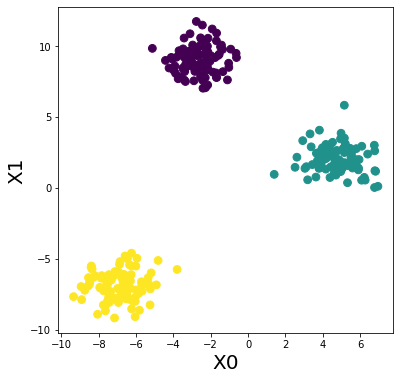

In [49]:
from sklearn import datasets
import matplotlib.pyplot as plt

X, y = datasets.make_blobs(n_samples=300, random_state=42)


fig, ax = plt.subplots(figsize=(6, 6))
plt.xlabel("X0", fontsize=20)
plt.ylabel("X1", fontsize=20) 
plt.scatter(X[:,0], X[:,1], s=60, c=y)
plt.show()
